In [4]:

import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt

from pathlib import Path
from core.utils import ensure_dirs
from core.utils import read_excel_from_s3
import ipynbname


In [5]:
# LOS FOLDERS y SCRIPS (notebook y .yaml) deben tener el mismo nombre

notebook_name = ipynbname.name()

ROOT_DATA = Path(f"../data/{notebook_name}")
ROOT_IMAGEN = Path(f"../images/{notebook_name}")
ensure_dirs(ROOT_DATA, ROOT_IMAGEN)
print(f"Carpetas verificadas/creadas:\n- {ROOT_DATA.resolve()}\n- {ROOT_IMAGEN.resolve()}")

Carpetas verificadas/creadas:
- /Users/juandavidrincon/Documents/galileo/data/raza_20_mayo
- /Users/juandavidrincon/Documents/galileo/images/raza_20_mayo


In [6]:
#df = pd.read_excel("../raw/Estadistico Adiflow RAZA.xlsx",
#                   sheet_name="Adiflow Peletizado", skiprows=1)
df = read_excel_from_s3(
    path="s3://galileo-c4e9a2f1/raza/Estadistico Adiflow RAZA.xlsx",
     sheet_name="Adiflow Peletizado", skiprows=1)

df["Adiflow"] = np.where(df["Con ADIFLOW"].isnull(), "Sin Adiflow", "Con Adiflow")
df.columns = [x.strip() for x in df.columns]
df = df[df['Maquina Empleada'].notnull()]

In [7]:
pd.to_numeric(df["%Humedad inicial"])

0      12.46
1      11.45
2       9.10
3       9.80
4      10.60
       ...  
597    10.50
598    10.40
599     9.57
600    10.60
601    10.70
Name: %Humedad inicial, Length: 601, dtype: float64

In [8]:
cols = [
    "Carga (puntos)", "Temperatura (°C)", "Presión (psi)",
    "% Consistencia",
    "%Humedad inicial",
    "% Humedad Final",
    "AW", "Kilos Mp Inicial", "Kilos Mp- Final", "%Desviación"
]

df[cols] = df[cols].apply(
    lambda s: pd.to_numeric(s.str.replace(',', '.'),
                            errors='coerce')
              if s.dtype == 'object' else s
)
df["sackoff_cal"] = (df["Kilos Mp- Final"]- df["Kilos Mp Inicial"])*100 / df["Kilos Mp Inicial"]
df['mes'] = pd.to_datetime(df['Fecha'],errors='coerce').dt.month
df['mes'].value_counts()

mes
4.0    286
3.0    154
5.0    134
2.0     19
1.0      1
7.0      1
Name: count, dtype: int64

In [9]:
df['Maquina Empleada'].unique()

array(['Pelet 1', 'Pelet 2 y 3', 'Pelet 4', 'Extruder 620',
       'Extruder 1020', 'Extruder 621'], dtype=object)

In [7]:
df_pel = df[df["Maquina Empleada"].isin(['Pelet 1', 'Pelet 2 y 3', 'Pelet 4'])]
df_ext = df[~df["Maquina Empleada"].isin(['Pelet 1', 'Pelet 2 y 3', 'Pelet 4'])]

In [8]:
def build_group(data, cols=['Maquina Empleada', 'Adiflow']):

    df_group = data.groupby(cols).agg(
        carga_prom=("Carga (puntos)", "mean"),
        temp_prom=("Temperatura (°C)", "mean"),
        presion_prom=("Presión (psi)", "mean"),
        durabilidad_prom=("% Consistencia", "median"),
        hum_ini=("%Humedad inicial", "mean"),
        hum_final=("% Humedad Final", "mean"),
        aw_prom=("AW", "mean"),
        kilos_iniciales=("Kilos Mp Inicial", "sum"),
        kilos_finales=("Kilos Mp- Final", "sum"),
        desv_prom=("%Desviación", "mean"),
    ).reset_index()
    df_group["prom_diff_hum_prom"] = df_group["hum_final"] - df_group["hum_ini"]
    df_group["sackoff"] = (df_group["kilos_finales"] - df_group["kilos_iniciales"])/df_group["kilos_iniciales"]*100
    df_group["ppc_hum"] = (df_group["hum_final"] - df_group["hum_ini"])/df_group["hum_ini"]#*100
    df_group  = round(df_group,2)

    df_pel_group_dep = df_group[cols+["kilos_iniciales","kilos_finales", "sackoff", "aw_prom", "hum_ini", "hum_final", "temp_prom", "presion_prom", "carga_prom", "durabilidad_prom"]]
    df_pel_group_dep = df_pel_group_dep.round(2)
    df_pel_group_dep["kilos_finales"] = df_pel_group_dep["kilos_finales"]/1000
    df_pel_group_dep["kilos_iniciales"] = df_pel_group_dep["kilos_iniciales"]/1000
    df_pel_group_dep = df_pel_group_dep.rename(columns={
        "kilos_finales": "Ton Finales",
        "kilos_iniciales": "Ton Iniciales",
        "sackoff": "Sackoff (%)",
        "aw_prom": "AW Prom",
        "hum_ini": "Hum Inicial Prom (%)",
        "hum_final": "Hum Final Prom (%)",
        "temp_prom": "Temp Prom (°C)",
        "presion_prom": "Presion Prom (Psi)",
        "carga_prom": "Carga Prom (Puntos)",
        "durabilidad_prom": "Durabilidad Prom (%)",
    })
    return df_pel_group_dep

In [14]:
df_pel_group = build_group(df_pel)
df_pel_group.to_csv(f"{ROOT_DATA}/data_pel_group_dep.csv", index=False)
df_pel_group["informe"] = "mayo"

df_pel_group.to_csv(f"../data/raza_junio/data_pel_group_dep_anterior.csv", index=False)

In [59]:
build_group(df_pel, cols=['Maquina Empleada', 'Adiflow','Producto'])


,Maquina Empleada,Adiflow,Producto,Ton Iniciales,Ton Finales,Sackoff (%),AW Prom,Hum Inicial Prom (%),Hum Final Prom (%),Temp Prom (°C),Presion Prom (Psi),Carga Prom (Puntos),Durabilidad Prom (%)
0,Pelet 1,Con Adiflow,Cavalia Actividad Moderada,24.483,24.840,1.46,0.69,10.11,12.03,62.67,45.0,37.5,95.55
1,Pelet 1,Con Adiflow,Cavalia Competencia Texturizado,6.017,5.946,-1.18,0.68,10.12,11.92,74.50,45.0,27.5,92.40
2,Pelet 1,Con Adiflow,Cavalia Potros,10.276,10.880,5.88,0.69,12.01,11.86,73.00,45.0,27.5,528.60
3,Pelet 1,Con Adiflow,Cavalia Yeguas,4.079,4.120,1.01,0.70,10.30,12.04,70.00,45.0,30.0,95.30
4,Pelet 1,Con Adiflow,Cerdas Lactancia,4.037,4.320,7.01,0.63,10.00,10.64,60.00,45.0,17.0,96.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,Pelet 4,Sin Adiflow,Raza del Corral Ponedora,4.182,4.160,-0.53,0.66,9.10,10.90,68.00,25.0,8.0,94.30
169,Pelet 4,Sin Adiflow,Utmost Engorde RAC,32.264,32.000,-0.82,0.66,9.50,11.40,72.00,25.0,6.0,92.00
170,Pelet 4,Sin Adiflow,Utmost Finalizador,8.017,7.910,-1.33,0.69,10.70,10.86,71.00,25.0,7.0,93.00
171,Pelet 4,Sin Adiflow,Utmost Levante 1,41.921,41.730,-0.46,0.68,9.78,11.36,68.75,25.0,6.0,91.70


In [60]:
df_ext_group = build_group(df_ext)
df_ext_group = df_ext_group[['Maquina Empleada', 'Adiflow', 'Ton Iniciales',
              'Ton Finales','Sackoff (%)', 'AW Prom',
              'Hum Inicial Prom (%)','Hum Final Prom (%)']]
df_ext_group.to_csv(f"{ROOT_DATA}/data_extruder_group_dep.csv", index=False)
df_ext_group

,Maquina Empleada,Adiflow,Ton Iniciales,Ton Finales,Sackoff (%),AW Prom,Hum Inicial Prom (%),Hum Final Prom (%)
0,Extruder 1020,Con Adiflow,2176.064,2091.036,-3.91,0.51,10.14,7.90
1,Extruder 1020,Sin Adiflow,1173.861,1120.362,-4.56,0.49,9.36,7.07
2,Extruder 620,Con Adiflow,1112.876,1075.328,-3.37,0.53,9.94,8.37
3,Extruder 620,Sin Adiflow,54.900,52.460,-4.44,0.53,9.37,7.95
4,Extruder 621,Con Adiflow,8.233,7.960,-3.32,0.48,10.00,6.68


In [61]:

def plot_comparative_moisture_change_by_machine(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    group_col: str,
    value_cols: Tuple[str, str],
    titles: Tuple[str, str],
    output_path: str,
    label_y: str = "Máquina Empleada",
    label_x: str = "Humedad (%)",
    colors: Tuple[str, str] = ("#94AF92", "#1C8074")
):
    """
    Genera gráfico comparativo horizontal de dos métricas por máquina o categoría.

    Parámetros:
    - df1, df2: DataFrames con datos para comparar.
    - group_col: Nombre de la columna de agrupación (ej. 'Máquina Empleada').
    - value_cols: Tuple con las columnas a comparar (ej. ('%Humedad inicial', '% Humedad Final')).
    - titles: Títulos de los subgráficos (uno para cada DataFrame).
    - output_path: Ruta del archivo de salida PNG.
    - label_y: Etiqueta del eje Y.
    - label_x: Etiqueta del eje X.
    - colors: Tuple con colores para barras inicial y final.
    """

    # Preparar los datos
    def prepare_df(df):
        df_plot = df.groupby(group_col)[list(value_cols)].mean()
        df_plot["Cambio_pct"] = df_plot[value_cols[1]] - df_plot[value_cols[0]]
        return df_plot

    df1_plot = prepare_df(df1)
    df2_plot = prepare_df(df2)

    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
    fig.patch.set_facecolor('none')

    for ax, (df_plot, title) in zip(axes, [(df1_plot, titles[0]), (df2_plot, titles[1])]):
        ax.set_facecolor('none')
        labels = df_plot.index.tolist()
        y = range(len(labels))
        height = 0.35

        # Barras horizontales
        ax.barh([i + height/2 for i in y], df_plot[value_cols[1]], height,
                label=value_cols[1], color=colors[1])
        ax.barh([i - height/2 for i in y], df_plot[value_cols[0]], height,
                label=value_cols[0], color=colors[0])

        # Anotar diferencia
        for i, pct in enumerate(df_plot["Cambio_pct"]):
            x_pos = df_plot[value_cols[1]].iloc[i]
            ax.text(
                x_pos + 0.01 * abs(x_pos) - 1,
                i - height/2,
                f'{pct:.1f}% {"▲" if pct > 0 else "▼"}',
                va='center', fontsize=15, fontweight='bold'
            )

        # Etiquetas
        ax.set_yticks(y)
        ax.set_yticklabels(labels, fontsize=14, fontweight='bold')
        ax.invert_yaxis()
        ax.set_ylabel(label_y, fontsize=18, fontweight='bold')
        ax.set_title(title, fontsize=22, fontweight='bold')
        ax.set_xlabel(label_x, fontsize=18, fontweight='bold')
        ax.tick_params(axis='x', labelsize=14)
        ax.legend(loc='lower right', fontsize=14)

        # Borde negro
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)

    fig.subplots_adjust(wspace=0.4)
    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)
    plt.show()
    print(f"✅ Gráfico guardado en: {output_path}")


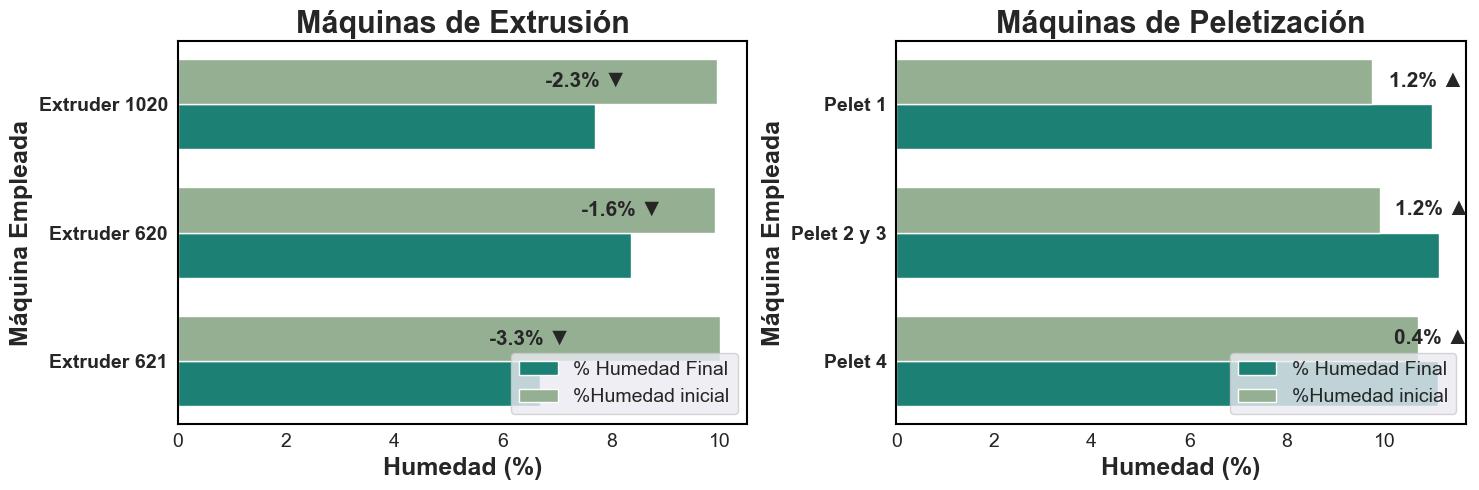

✅ Gráfico guardado en: ../images/raza_20_mayo/comparacion_humedad.png


In [62]:
plot_comparative_moisture_change_by_machine(
    df1=df_ext,
    df2=df_pel,
    group_col="Maquina Empleada",
    value_cols=("%Humedad inicial", "% Humedad Final"),
    titles=("Máquinas de Extrusión", "Máquinas de Peletización"),
    output_path=f"{ROOT_IMAGEN}/comparacion_humedad.png"
)


In [63]:

def plot_aw_comparison_by_machine_and_adiflow(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    group_col: str,
    condition_col: str,
    value_col: str,
    titles: Tuple[str, str],
    output_path: str,
    color_map: Dict[str, str] = None,
    figsize: Tuple[int, int] = (14, 5),
    x_limit: Tuple[float, float] = (0, 1)
):
    """
    Dibuja comparación horizontal de Aw por máquina, diferenciando por condición (ej. Adiflow),
    para dos DataFrames (extrusión y peletización).

    Parámetros:
    - df1, df2: DataFrames para los dos paneles.
    - group_col: Columna con el nombre de la máquina o grupo.
    - condition_col: Columna con la condición (ej. 'Adiflow').
    - value_col: Columna numérica a comparar (ej. 'AW Prom').
    - titles: Tupla con títulos de los paneles (ej. ("Extrusión", "Peletización")).
    - output_path: Ruta para guardar el gráfico en PNG.
    - color_map: Diccionario con colores por condición (ej. {'Con Adiflow': '#94AF92'}).
    - figsize: Tamaño de la figura.
    - x_limit: Límite horizontal (xmin, xmax) para las barras.
    """

    if color_map is None:
        color_map = {
            "Sin Adiflow": "#1C8074",
            "Con Adiflow": "#94AF92",
        }

    BAR_HEIGHT = 0.35

    def plot_panel(df, title, ax):
        pivot = (
            df.groupby([group_col, condition_col], as_index=False)[value_col]
            .mean()
            .pivot(index=group_col, columns=condition_col, values=value_col)
            .fillna(0)
            .sort_index(ascending=True)
        )

        y = range(len(pivot))
        offset = BAR_HEIGHT / 2

        for i, (cond, color) in enumerate(color_map.items()):
            if cond not in pivot.columns:
                continue

            y_pos = [yy - offset if i == 0 else yy + offset for yy in y]
            bars = ax.barh(
                y=y_pos,
                width=pivot[cond],
                height=BAR_HEIGHT,
                color=color,
                label=cond,
                edgecolor="black",
                linewidth=1.3,
                zorder=3
            )

            for bar in bars:
                w = bar.get_width()
                y_text = bar.get_y() + bar.get_height() / 2
                ax.text(
                    w + 0.02, y_text,
                    f"{w:.2f}",
                    va="center", ha="left",
                    fontsize=11, fontweight="bold",
                )

        ax.set_yticks(y)
        ax.set_yticklabels(pivot.index, fontsize=13, fontweight="bold", color="black")
        ax.set_xlim(*x_limit)
        ax.set_xlabel("Aw", fontsize=14, fontweight="bold")
        ax.set_title(title, fontsize=18, fontweight="bold")
        ax.invert_yaxis()
        ax.grid(axis="x", linestyle="--", alpha=0.3, zorder=0)
        ax.set_facecolor("none")
        for spine in ax.spines.values():
            spine.set_edgecolor("black")
            spine.set_linewidth(1.2)

    # Crear figura
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=False)
    fig.patch.set_facecolor("none")

    plot_panel(df1, titles[0], axes[0])
    plot_panel(df2, titles[1], axes[1])

    # Leyenda única
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=2, fontsize=13, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)
    plt.show()
    print(f"✅ Gráfico guardado en: {output_path}")


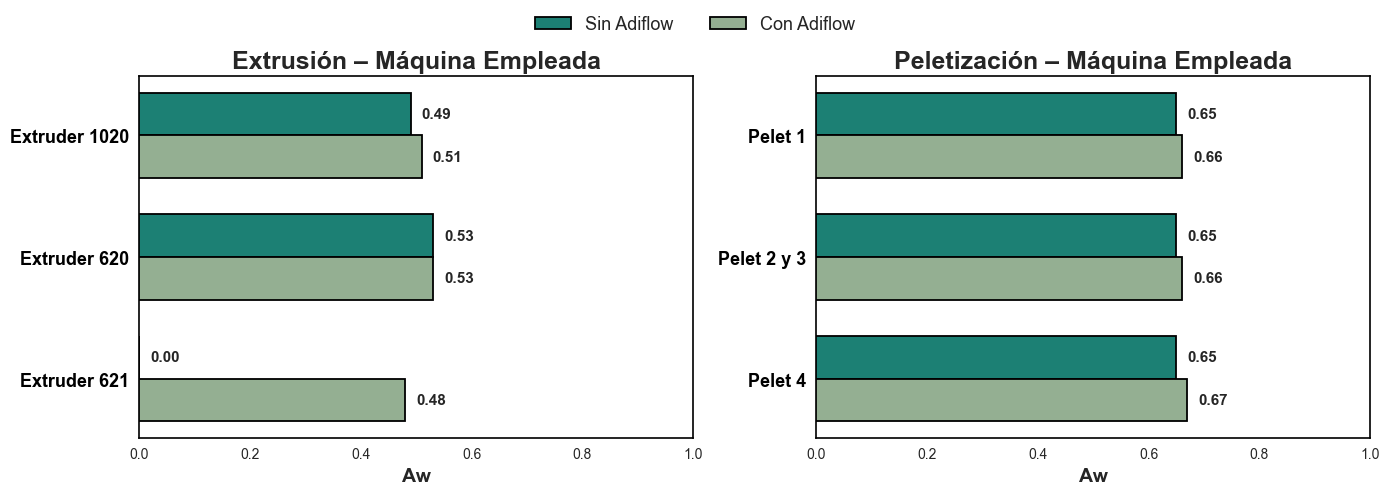

✅ Gráfico guardado en: ../images/raza_20_mayo/comparacion_aw_adiflow.png


In [64]:
plot_aw_comparison_by_machine_and_adiflow(
    df1=df_ext_group,
    df2=df_pel_group,
    group_col="Maquina Empleada",
    condition_col="Adiflow",
    value_col="AW Prom",
    titles=("Extrusión – Máquina Empleada", "Peletización – Máquina Empleada"),
    output_path=f"{ROOT_IMAGEN}/comparacion_aw_adiflow.png"
)


In [65]:

def plot_humidity_change_by_group_and_condition_4panel(
    df_dict: Dict[str, pd.DataFrame],
    condition_col: str,
    group_col: str,
    initial_col: str,
    final_col: str,
    condition_values: Tuple[str, str],
    titles: Tuple[str, str],
    output_path: str,
    bar_height: float = 0.35,
    figsize: Tuple[int, int] = (18, 10),
    xlim: Tuple[float, float] = (0, 13),
    colors: Tuple[str, str] = ("#94AF92", "#1C8074")  # inicial, final
):
    """
    Dibuja un gráfico 2x2 comparando humedad inicial vs final por máquina y condición.

    Parámetros:
    - df_dict: Diccionario con claves como 'Extrusión', 'Peletización' y valores DataFrames.
    - condition_col: Nombre de la columna de condición (ej. 'Adiflow').
    - group_col: Columna con las máquinas o grupos.
    - initial_col, final_col: Columnas de humedad inicial y final.
    - condition_values: Tupla con ('Con', 'Sin') Adiflow o condiciones binarias.
    - titles: Títulos para los dos grupos principales (eje Y).
    - output_path: Ruta donde guardar el PNG.
    - bar_height: Altura de las barras.
    - figsize: Tamaño de la figura.
    - xlim: Límite del eje X.
    - colors: Colores para inicial y final.
    """

    def plot_panel(ax, df, title):
        df_plot = (
            df.groupby(group_col)[[initial_col, final_col]]
              .mean()
              .sort_index()
        )
        df_plot["Cambio_pct"] = df_plot[final_col] - df_plot[initial_col]

        y_pos = range(len(df_plot))
        labels = df_plot.index.tolist()

        # Barras
        ax.barh([y + bar_height/2 for y in y_pos], df_plot[initial_col],
                bar_height, label="Humedad Inicial", color=colors[0])
        ax.barh([y - bar_height/2 for y in y_pos], df_plot[final_col],
                bar_height, label="Humedad Final", color=colors[1])

        # Anotaciones
        for i, pct in enumerate(df_plot["Cambio_pct"]):
            x_val = df_plot[final_col].iloc[i]
            ax.text(
                x_val + 0.01 * max(1, abs(x_val)), i - bar_height/2,
                f"{pct:+.1f}% {'▲' if pct > 0 else '▼'}",
                va='center', ha='left', fontsize=13, fontweight='bold'
            )

        # Estética
        ax.set_title(title, fontsize=16, fontweight='bold')
        ax.set_xlabel("Humedad (%)", fontsize=13, fontweight='bold')
        ax.set_yticks(y_pos)
        ax.set_yticklabels(labels, fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.set_xlim(xlim)
        ax.tick_params(axis='x', labelsize=12)
        ax.set_facecolor('none')
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.3)

    # Crear figura
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    fig.patch.set_facecolor("none")

    for i, (group_key, df_group) in enumerate(df_dict.items()):
        for j, cond in enumerate(condition_values):
            filtered = df_group[df_group[condition_col] == cond]
            plot_panel(
                axes[i, j],
                filtered,
                f"{titles[i]} – {cond}"
            )

    # Leyenda única
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=14, frameon=False)

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)
    plt.show()
    print(f"✅ Gráfico guardado en: {output_path}")


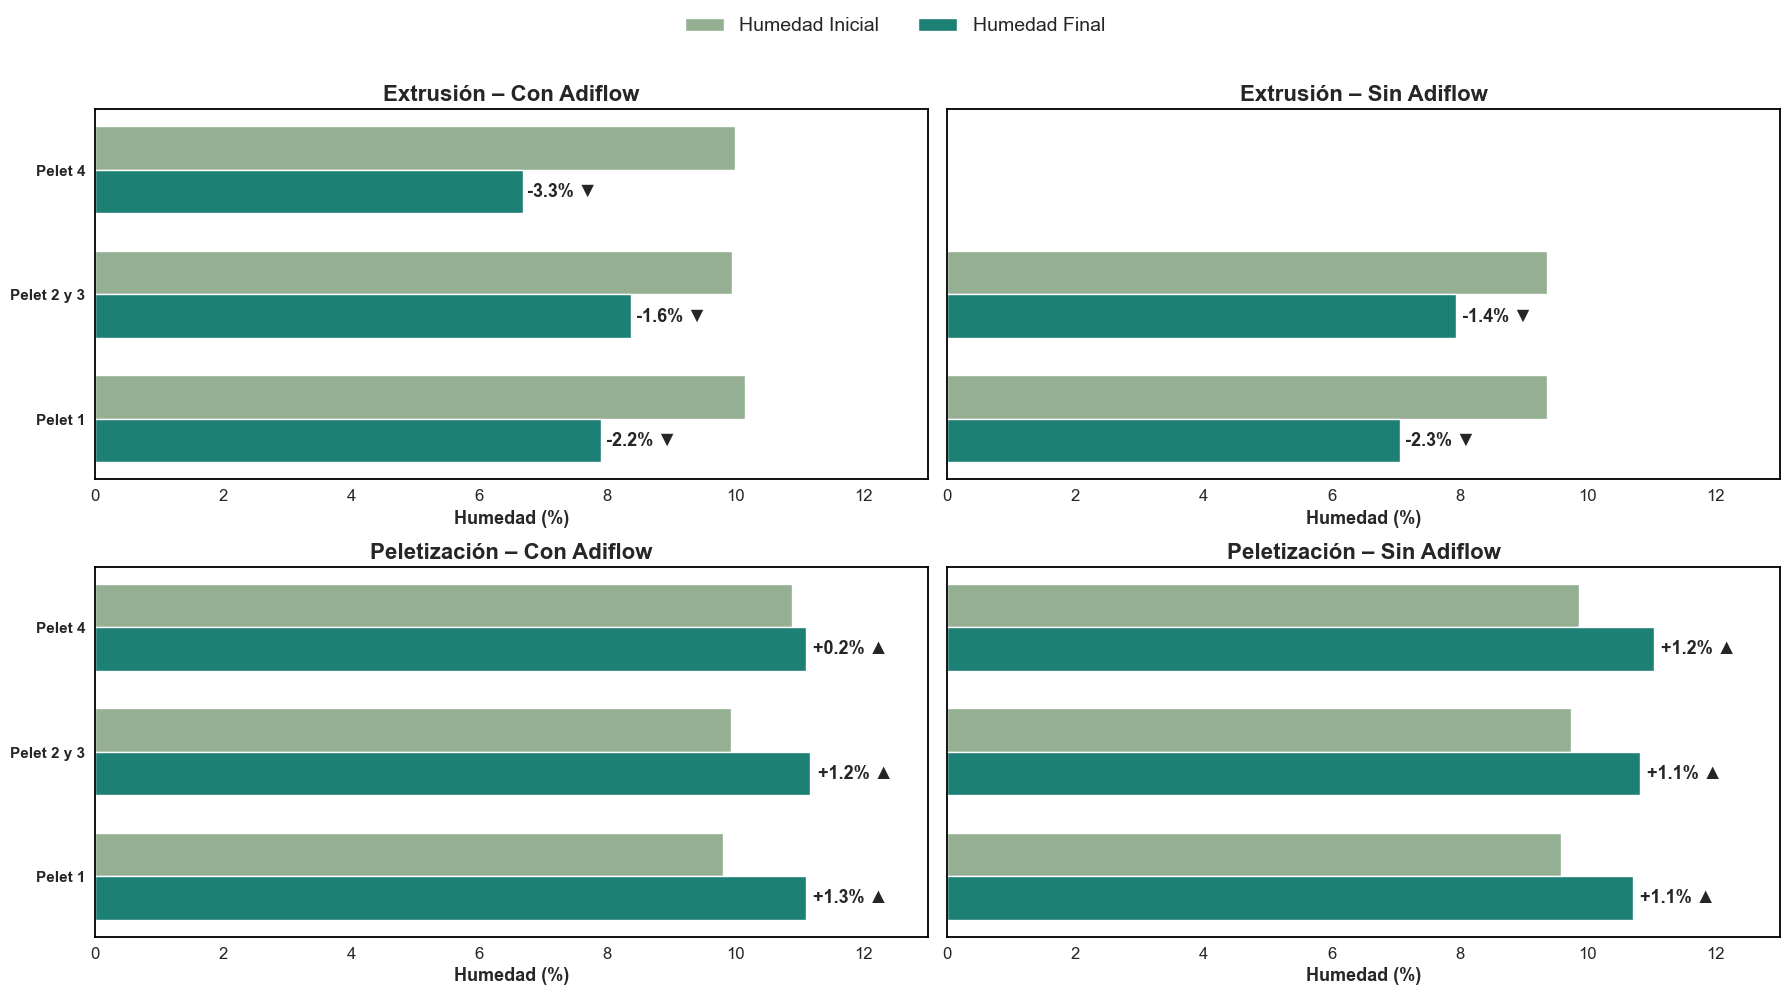

✅ Gráfico guardado en: ../images/raza_20_mayo/comparacion_humedad_4panel.png


In [66]:
plot_humidity_change_by_group_and_condition_4panel(
    df_dict={
        "Extrusión": df_ext,
        "Peletización": df_pel
    },
    condition_col="Adiflow",
    group_col="Maquina Empleada",
    initial_col="%Humedad inicial",
    final_col="% Humedad Final",
    condition_values=("Con Adiflow", "Sin Adiflow"),
    titles=("Extrusión", "Peletización"),
    output_path=f"{ROOT_IMAGEN}/comparacion_humedad_4panel.png"
)


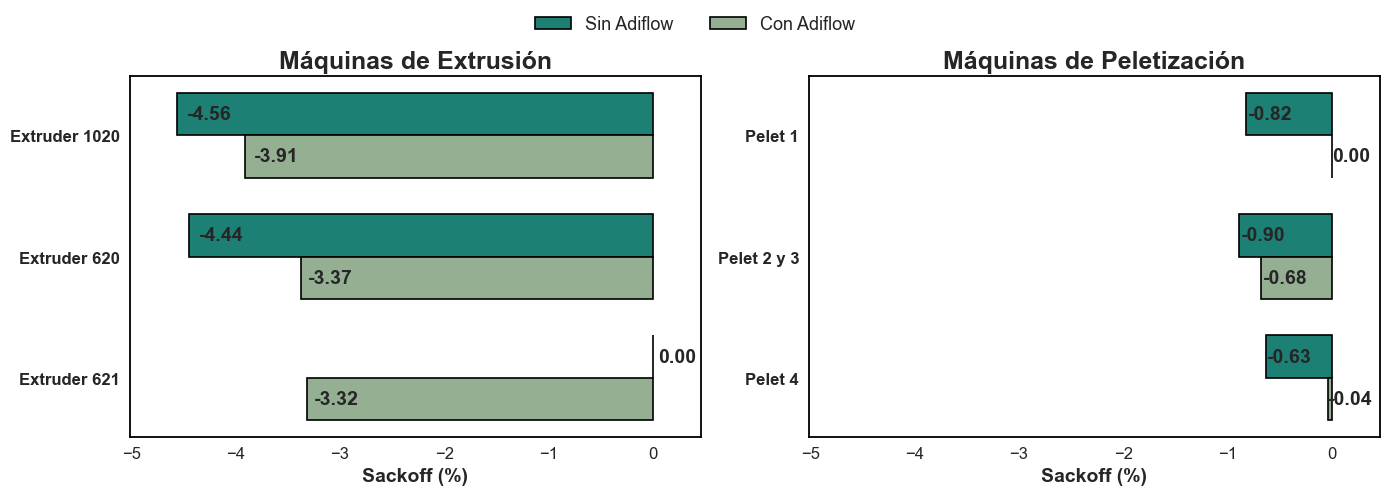

In [69]:

COLOR_SIN  = '#1C8074'
COLOR_CON  = '#94AF92'
BAR_HEIGHT = 0.35
FIGSIZE    = (14, 5)
ROOT_IMAGEN = "../images/raza_humedad"   # ajusta si tu ruta es distinta

# ──────────────────────────────────────────────────────────────────────
# 1.  PREPARAR TABLA DE SACKOFF (kilos_finales − kilos_iniciales)
# ──────────────────────────────────────────────────────────────────────
def build_sackoff_df(data, cols=('Maquina Empleada', 'Adiflow')):
    """
    Devuelve un DataFrame con:
        Maquina Empleada | Adiflow | sackoff
    donde sackoff = kilos_finales − kilos_iniciales
    """
    df_group = (
        data.groupby(list(cols), as_index=False)
            .agg(
                kilos_iniciales=("Kilos Mp Inicial", "sum"),
                kilos_finales=("Kilos Mp- Final", "sum"),
            )
    )
    df_group["sackoff"] = (df_group["kilos_finales"] - df_group["kilos_iniciales"])/df_group["kilos_iniciales"]*100
    return df_group

# Construir las bases para Extrusión y Peletización
df_ext_base = build_sackoff_df(df_ext)   # df_ext debe tener las columnas usadas
df_pel_base = build_sackoff_df(df_pel)

# ──────────────────────────────────────────────────────────────────────
# 2.  FUNCIÓN PARA DIBUJAR UN PANEL (Extrusión / Peletización)
# ──────────────────────────────────────────────────────────────────────
def plot_sackoff_panel(df_base, title, ax, xlim=None):
    """
    Grafica barras horizontales de sackoff CON / SIN Adiflow por máquina.
    """
    df_plot = (
        df_base.pivot(index='Maquina Empleada',
                      columns='Adiflow',
                      values='sackoff')
                .fillna(0)
                .sort_index()
    )

    labels = df_plot.index.tolist()
    y_pos  = range(len(labels))

    # Dibujar barras agrupadas
    for status, color, offset in [('Sin Adiflow', COLOR_SIN, -BAR_HEIGHT/2),
                                  ('Con Adiflow', COLOR_CON,  BAR_HEIGHT/2)]:
        if status not in df_plot.columns:
            continue
        values = df_plot[status]
        bars = ax.barh(
            [y + offset for y in y_pos],
            values, BAR_HEIGHT,
            color=color, edgecolor='black', linewidth=1.2,
            label=status, zorder=3
        )
        # Anotar valores
        for bar in bars:
            w = bar.get_width()
            y_txt = bar.get_y() + bar.get_height() / 2
            ax.text(
                w + (0.02 * abs(w) if w else 0.05),  # pequeño desplazamiento
                y_txt,
                f'{w:.2f}',
                va='center', ha='left',
                fontsize=14, fontweight='bold'
            )

    # Estética del panel
    ax.set_title(title, fontsize=18, fontweight='bold')
    ax.set_xlabel('Sackoff (%)', fontsize=14, fontweight='bold')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=12, fontweight='bold')
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=12)
    ax.set_facecolor('none')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

    # Límites X comunes o automáticos
    if xlim is not None:
        ax.set_xlim(*xlim)
    else:
        max_abs = df_plot.abs().to_numpy().max()
        ax.set_xlim(-max_abs*1.1, max_abs*0.1)

# ──────────────────────────────────────────────────────────────────────
# 3.  DIBUJAR FIGURA 1×2
# ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=FIGSIZE, sharey=False)
fig.patch.set_facecolor('none')

# Determinar un rango X compartido (opcional)
max_abs = max(df_ext_base['sackoff'].abs().max(),
              df_pel_base['sackoff'].abs().max())
XLIM = (-max_abs*1.1, max_abs*0.1)   # asumiendo valores negativos

plot_sackoff_panel(df_ext_base, 'Máquinas de Extrusión',   axes[0], xlim=XLIM)
plot_sackoff_panel(df_pel_base, 'Máquinas de Peletización', axes[1], xlim=XLIM)

# Leyenda única
handles, labels_legend = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_legend, loc='upper center',
           ncol=2, fontsize=13, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f"{ROOT_IMAGEN}/comparacion_sackoff_adiflow.png",
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()


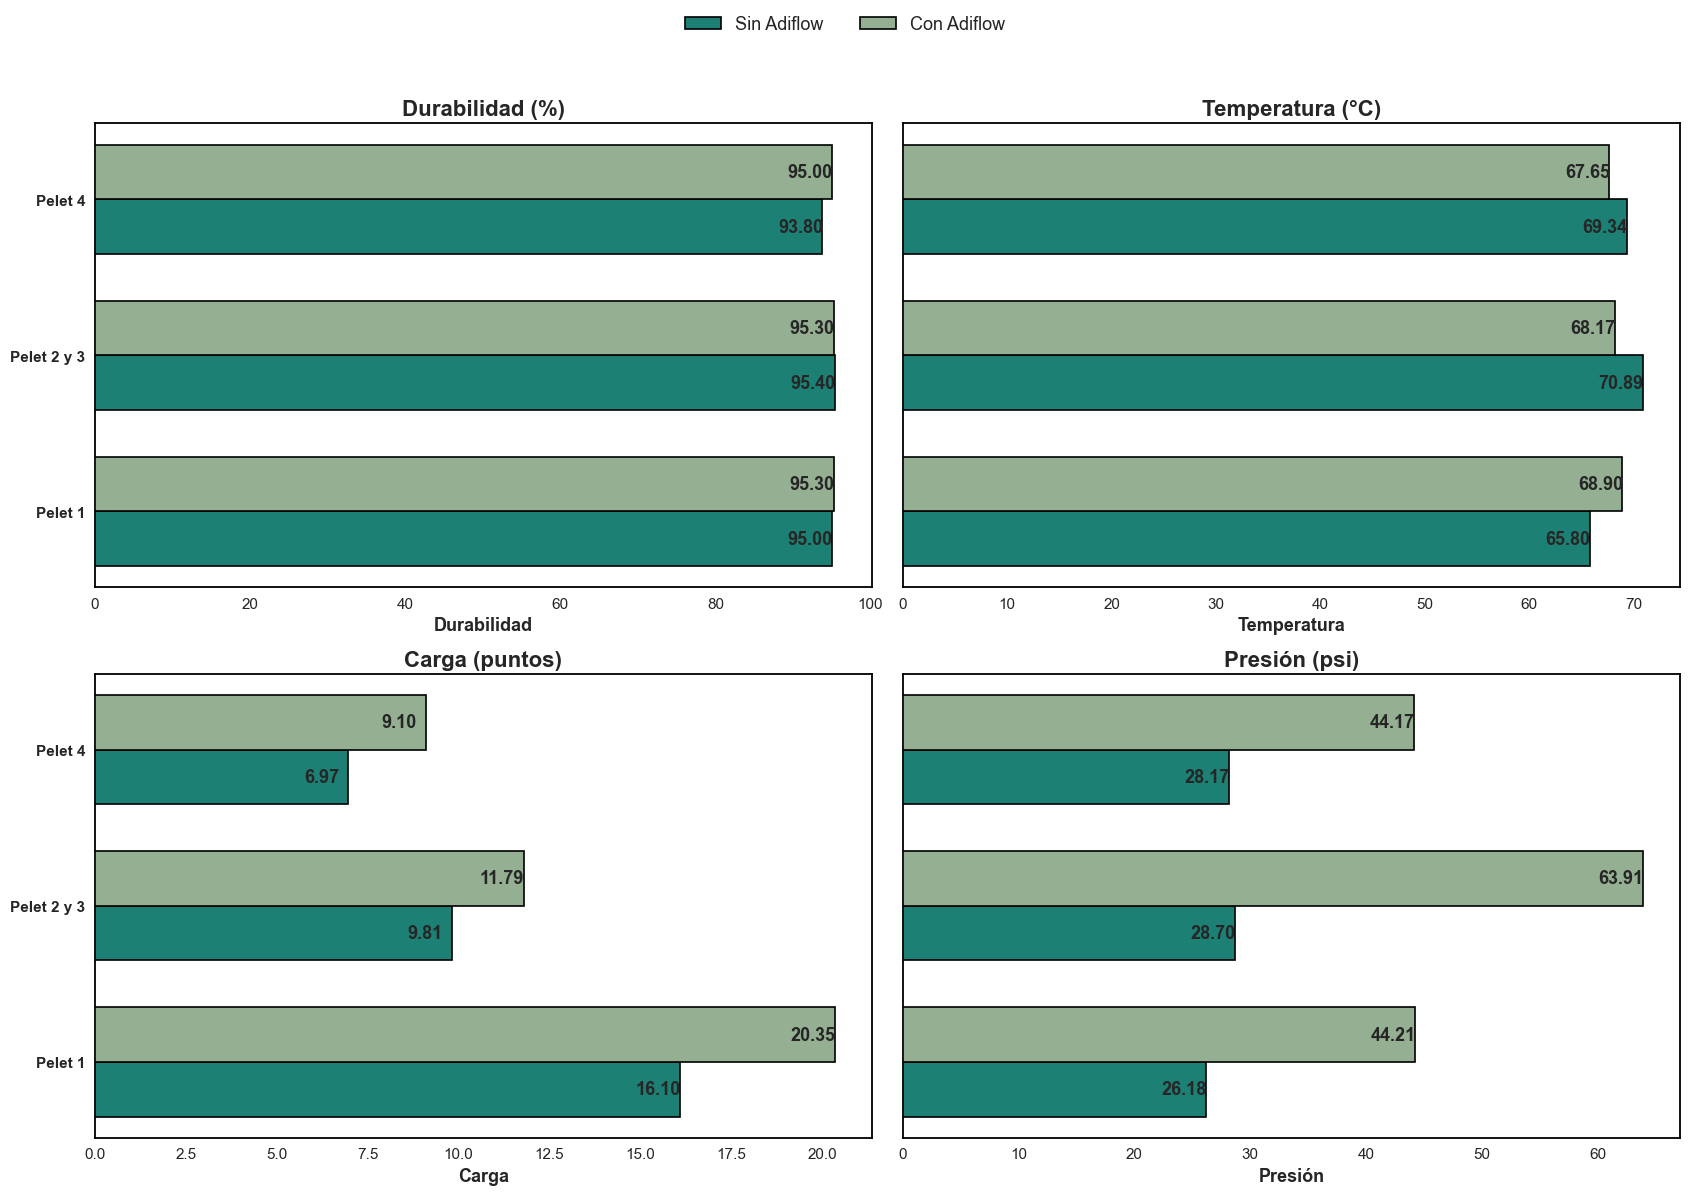

In [70]:


# ──────────────────────────────────────────────────────────────────────
# 1.  CONFIGURACIÓN GENERAL
# ──────────────────────────────────────────────────────────────────────
COLOR_SIN = '#1C8074'     # verde oscuro  (Sin Adiflow)
COLOR_CON = '#94AF92'     # verde claro   (Con Adiflow)
BAR_H     = 0.35          # grosor de cada barra
FIGSIZE   = (17, 12)      # tamaño (ancho, alto) de la figura final
ROOT_IMG  = "../images/raza_humedad"   # cambia a tu ruta si es distinta

# ──────────────────────────────────────────────────────────────────────
# 2.  MÉTRICAS A MOSTRAR (columna → etiqueta legible)
# ──────────────────────────────────────────────────────────────────────
METRICS = {
    "Durabilidad Prom (%)": "Durabilidad (%)",
    "Temp Prom (°C)":        "Temperatura (°C)",
    "Carga Prom (Puntos)":       "Carga (puntos)",
    "Presion Prom (Psi)":     "Presión (psi)",
}

# ──────────────────────────────────────────────────────────────────────
# 3.  PREPARAR DATAFRAME BASE CON PROMEDIOS POR MÁQUINA + ADIFLOW
# ──────────────────────────────────────────────────────────────────────
def build_metric_df(data, cols_metric):
    """
    Devuelve un DF con: Maquina Empleada | Adiflow | [métricas …]
    promediados por la combinación (máquina, adiflow).
    """
    agg_dict = {col: ("mean") for col in cols_metric}
    df_group = data.groupby(["Maquina Empleada", "Adiflow"], as_index=False).agg(agg_dict)
    return df_group

cols_needed = list(METRICS.keys())
df_base     = build_metric_df(df_pel_group, cols_needed)      # df_full = tu DataFrame original

# ──────────────────────────────────────────────────────────────────────
# 4.  FUNCIÓN AUXILIAR PARA UN SUBPLOT (UNA MÉTRICA)
# ──────────────────────────────────────────────────────────────────────
def plot_metric_panel(df_base, metric_col, pretty_name, ax):
    """
    Dibuja barras horizontales Con/Sin Adiflow por máquina para la métrica dada.
    """
    df_pivot = (
        df_base.pivot(index='Maquina Empleada',
                      columns='Adiflow',
                      values=metric_col)
                .fillna(0)
                .sort_index()
    )
    labels = df_pivot.index.tolist()
    y_pos  = range(len(labels))

    for status, color, offset in [
        ('Sin Adiflow', COLOR_SIN, -BAR_H/2),
        ('Con Adiflow', COLOR_CON,  BAR_H/2),
    ]:
        if status not in df_pivot.columns:
            continue
        values = df_pivot[status]
        ax.barh(
            [y + offset for y in y_pos],
            values, BAR_H,
            color=color, edgecolor='black', linewidth=1.2,
            label=status if metric_col == list(METRICS.keys())[0] else None,  # leyenda solo 1ª vez
            zorder=3,
        )
        # anotación numérica
        for y, val in zip(y_pos, values):
            ax.text(
                val - 0.06 * (df_pivot.max().max() if val >= 0 else -df_pivot.min().min()),
                y + offset,
                f'{val:.2f}',
                va='center', ha='left',
                fontsize=13, fontweight='bold'
            )

    # estética
    ax.set_title(pretty_name, fontsize=16, fontweight='bold')
    ax.set_xlabel(pretty_name.split()[0], fontsize=13, fontweight='bold')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels, fontsize=11, fontweight='bold')
    ax.invert_yaxis()
    ax.tick_params(axis='x', labelsize=11)
    ax.set_facecolor('none')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.3)

# ──────────────────────────────────────────────────────────────────────
# 5.  CREAR FIGURA 2×2 CON DURABILIDAD, TEMPERATURA, CARGA, PRESIÓN
# ──────────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=FIGSIZE, sharey=True)
fig.patch.set_facecolor('none')

for ax, (metric_col, pretty_name) in zip(axes.flat, METRICS.items()):
    plot_metric_panel(df_base, metric_col, pretty_name, ax)

# leyenda única (solo se añadió a la primera)
handles, labels_leg = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels_leg, loc='upper center',
           ncol=2, fontsize=13, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.savefig(f"{ROOT_IMAGEN}/metrics_con_sin_adiflow.png",
            dpi=300, bbox_inches='tight', transparent=True)
plt.show()
